In [295]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor


Импорт библиотек

In [296]:
ca = pd.read_excel(r'C:\Users\User\Documents\GitHub\Intensiv_3\Dataset\data\train.xlsx', engine='openpyxl')

Проверка данных (В нашем случае не нужно ничего заполнять)

In [297]:
ca.head(12)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Проверка

In [298]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


Дата

In [299]:
ca['dt'] = pd.to_datetime(ca['dt'], errors='coerce')

ca['День недели'] = ca['dt'].dt.weekday
ca['Месяц'] = ca['dt'].dt.month
ca['Год'] = ca['dt'].dt.year

Мини-проверка

In [300]:
if 'dt' in ca.columns:
    print("Столбец 'dt' найден.")
    ca['dt'] = pd.to_datetime(ca['dt'], errors='coerce') 
else:
    print("Столбец 'dt' отсутствует.")

Столбец 'dt' найден.


Проверяем

In [301]:
print("Имена столбцов:")
print(ca.columns)

Имена столбцов:
Index(['dt', 'Цена на арматуру', 'День недели', 'Месяц', 'Год'], dtype='object')


In [302]:
ca.rename(columns={
    'Год': 'Год',
    'Цена на арматуру': 'Цена_на_арматуру',
    'Цена на арматуру_lag1': 'Цена_на_арматуру_lag1',
    'Цена на арматуру_lag2': 'Цена_на_арматуру_lag2',
    'День недели': 'Номер_недели',
    'Месяц': 'Месяц'  
}, inplace=True)

Модель CatBoostRegressor

0:	learn: 12280.2372719	total: 2.92ms	remaining: 1.46s
100:	learn: 1419.0594205	total: 168ms	remaining: 664ms
200:	learn: 1000.8971641	total: 313ms	remaining: 466ms
300:	learn: 756.0690972	total: 408ms	remaining: 270ms
400:	learn: 616.3536782	total: 501ms	remaining: 124ms
499:	learn: 527.5949406	total: 597ms	remaining: 0us
Прогноз на 6 недель вперед: [46185.23591153665, 45794.67733510864, 45794.67733510864, 45794.67733510864, 45794.67733510864, 45794.67733510864]


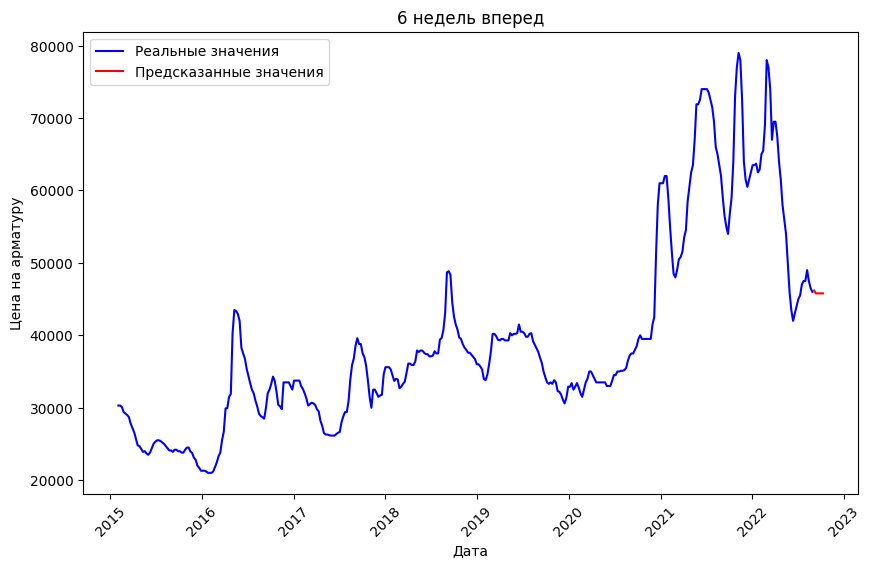

In [304]:
ca['Цена_на_арматуру_lag1'] = ca['Цена_на_арматуру'].shift(1)
ca['Цена_на_арматуру_lag2'] = ca['Цена_на_арматуру'].shift(2)

ca = ca.dropna(subset=['Цена_на_арматуру_lag1', 'Цена_на_арматуру_lag2'])

required_columns = ['Год', 'Номер_недели', 'Цена_на_арматуру_lag1', 'Цена_на_арматуру_lag2', 'Цена_на_арматуру']
missing_columns = [col for col in required_columns if col not in ca.columns]

if missing_columns:
    print(f"Отсутствуют следующие столбцы: {missing_columns}")
else:
    X = ca[['Год', 'Номер_недели', 'Цена_на_арматуру_lag1', 'Цена_на_арматуру_lag2']]
    y = ca['Цена_на_арматуру']

    model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)

    model.fit(X, y)

    def predict_future(model, ca, N, features):
        future_predictions = []
        last_row = ca.iloc[-1][features].values.reshape(1, -1)
        
        for i in range(N):
            pred = model.predict(last_row)
            future_predictions.append(pred[0])
            
            last_row = last_row.copy()
            last_row[0, features.index('Номер_недели')] += 1  
            last_row[0, features.index('Год')] = ca['Год'].iloc[-1]  
            last_row[0, features.index('Цена_на_арматуру_lag2')] = last_row[0, features.index('Цена_на_арматуру_lag1')]
            last_row[0, features.index('Цена_на_арматуру_lag1')] = pred  

        return future_predictions

    try:
        N = int(input("Введите количество недель для предсказания (от 1 до 6): "))
        if N < 1 or N > 6:
            print("Введите число от 1 до 6!")
        else:
            future_predictions = predict_future(model, ca, N, ['Год', 'Номер_недели', 'Цена_на_арматуру_lag1', 'Цена_на_арматуру_lag2'])
            print(f"Прогноз на {N} недель вперед: {future_predictions}")
            
            plt.figure(figsize=(10, 6))
            plt.plot(ca['dt'], y, label='Реальные значения', color='blue')
            
            future_dates = pd.date_range(start=ca['dt'].iloc[-1] + pd.Timedelta(weeks=1), periods=N, freq='W-MON')
            
            plt.plot(future_dates, future_predictions, label='Предсказанные значения', color='red', linestyle='-')
            
            plt.xlabel('Дата')
            plt.ylabel('Цена на арматуру')
            plt.title(f'{N} недель вперед')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()

    except ValueError:
        print("Ошибка: введите корректное число!")